In [1]:
import pandas as pd

# CSV ফাইল path দিয়ে লোড করো
df = pd.read_csv("UCI_Credit_Card.csv")

# প্রথম ৫টি row দেখার জন্য
print(df.head())

# columns নাম দেখার জন্য
print(df.columns)


   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0       0.0       0.0   

In [2]:
import sqlite3
import pandas as pd

# CSV ফাইল লোড
df = pd.read_csv("UCI_Credit_Card.csv")


In [3]:
# SQLite database create/connect
conn = sqlite3.connect("credit_data.db")

# DataFrame কে SQL table এ convert
df.to_sql("credit_card", conn, if_exists="replace", index=False)


30000

In [5]:
query_filter = """
SELECT LIMIT_BAL, AGE, SEX, "default.payment.next.month"
FROM credit_card
WHERE AGE > 30 AND "default.payment.next.month" = 1
LIMIT 5;
"""
cur.execute(query_filter)
print(cur.fetchall())


[(120000.0, 39, 2, 1), (450000.0, 40, 2, 1), (50000.0, 33, 1, 1), (150000.0, 46, 2, 1), (70000.0, 42, 1, 1)]


In [7]:
# Rename columns
df.rename(columns={'default.payment.next.month':'default_payment_next_month'}, inplace=True)

# পুনরায় table এ write
df.to_sql("credit_card", conn, if_exists="replace", index=False)


30000

In [9]:
import sqlite3
import pandas as pd

# DB connect
conn = sqlite3.connect("credit_data.db")

# SQL query
query = """
SELECT LIMIT_BAL, AGE, SEX, default_payment_next_month
FROM credit_card
WHERE AGE > 30 AND default_payment_next_month = 1
LIMIT 5;
"""

# pandas দিয়ে load করা
result = pd.read_sql_query(query, conn)
print(result)


   LIMIT_BAL  AGE  SEX  default_payment_next_month
0   120000.0   39    2                           1
1   450000.0   40    2                           1
2    50000.0   33    1                           1
3   150000.0   46    2                           1
4    70000.0   42    1                           1


In [10]:
# ধরো df_merged এ সব column আছে (internal + external)
df['risk_score'] = 0

# Basic rules
df.loc[df['LIMIT_BAL'] < 50000, 'risk_score'] += 2
df.loc[df['AGE'] < 30, 'risk_score'] += 1

# Payment history contribution
pay_cols = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
df['payment_delays'] = df[pay_cols].apply(lambda x: sum(x > 0), axis=1)
df['risk_score'] += df['payment_delays']

# External factor (if available)
# df['risk_score'] += df['Unemployment_Rate'] * 0.5

# দেখাও top 5
print(df[['LIMIT_BAL','AGE','risk_score','default_payment_next_month']].head())


   LIMIT_BAL  AGE  risk_score  default_payment_next_month
0    20000.0   24           5                           1
1   120000.0   26           3                           1
2    90000.0   34           0                           0
3    50000.0   37           0                           0
4    50000.0   57           0                           0


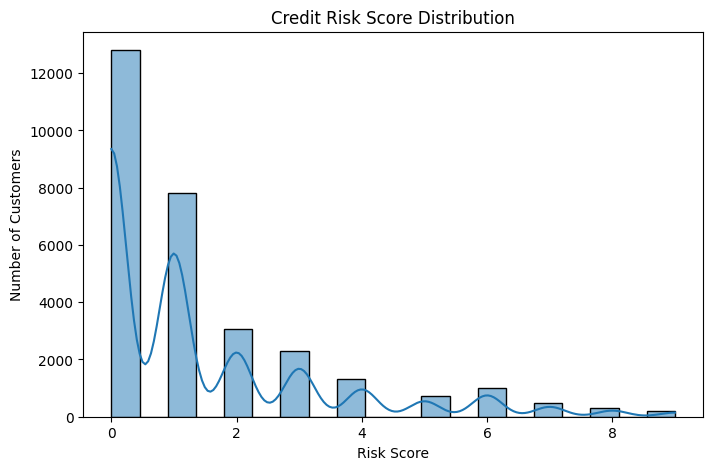

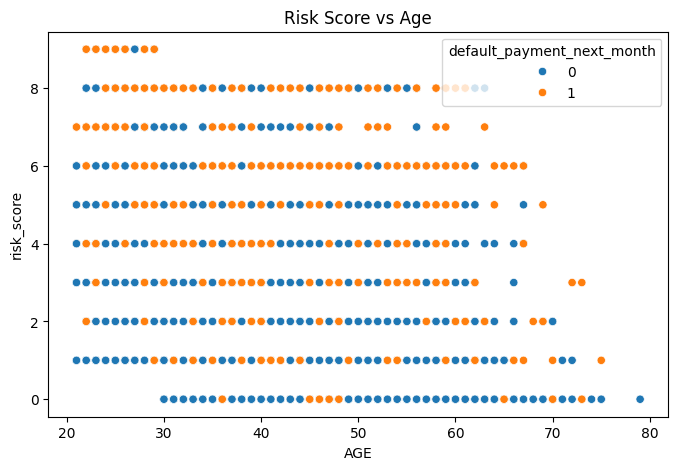

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Risk score distribution
plt.figure(figsize=(8,5))
sns.histplot(df['risk_score'], bins=20, kde=True)
plt.title("Credit Risk Score Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Number of Customers")
plt.show()

# Risk score vs Age
plt.figure(figsize=(8,5))
sns.scatterplot(x='AGE', y='risk_score', hue='default_payment_next_month', data=df)
plt.title("Risk Score vs Age")
plt.show()


In [12]:
df.to_csv("credit_risk_with_score.csv", index=False)


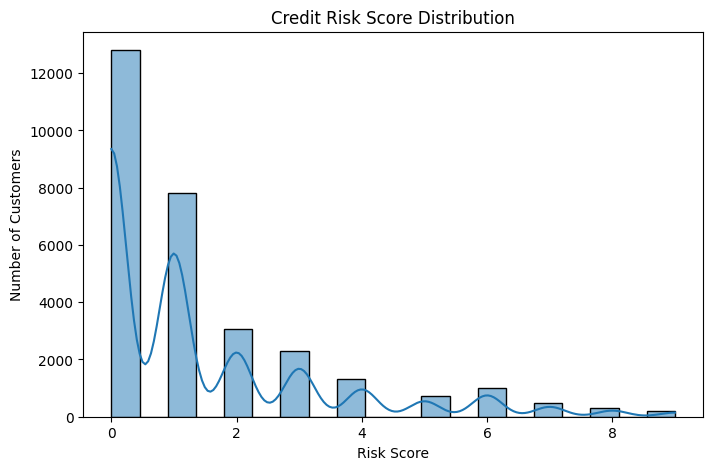

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['risk_score'], bins=20, kde=True)
plt.title("Credit Risk Score Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Number of Customers")
plt.show()


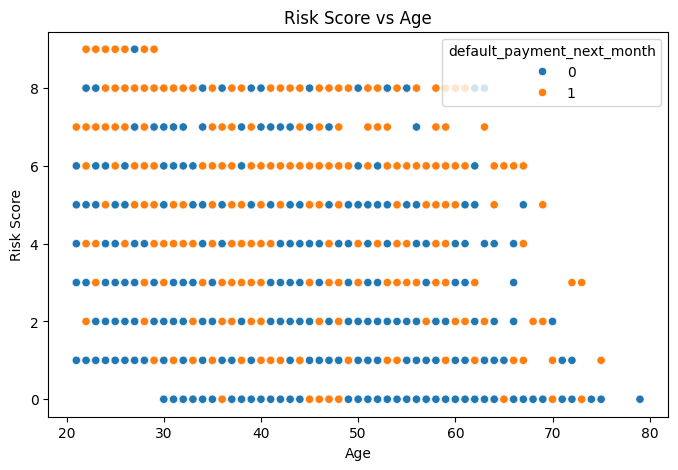

In [14]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='AGE', y='risk_score', hue='default_payment_next_month', data=df)
plt.title("Risk Score vs Age")
plt.xlabel("Age")
plt.ylabel("Risk Score")
plt.show()


In [15]:
# SQLite DB connect
conn = sqlite3.connect("credit_data.db")

# SQL query
query = """
SELECT AGE, AVG(LIMIT_BAL) as avg_limit, SUM(default_payment_next_month) as defaults
FROM credit_card
WHERE AGE > 30
GROUP BY AGE;
"""

# Query run করে pandas DataFrame এ load
result = pd.read_sql_query(query, conn)
print(result)

    AGE      avg_limit  defaults
0    31  193755.135579       229
1    32  200397.236615       225
2    33  196815.008726       215
3    34  199388.984509       231
4    35  198292.902066       226
5    36  195216.606498       254
6    37  200566.762728       229
7    38  192923.728814       194
8    39  205880.503145       199
9    40  188448.275862       187
10   41  189672.330097       185
11   42  187969.370277       185
12   43  180850.746269       150
13   44  186600.000000       162
14   45  172706.645057       116
15   46  175817.543860       157
16   47  167924.151697       120
17   48  168703.862661       104
18   49  172123.893805       119
19   50  180851.581509       101
20   51  160558.823529        88
21   52  153618.421053        78
22   53  174461.538462        74
23   54  171700.404858        56
24   55  150956.937799        57
25   56  146910.112360        49
26   57  160819.672131        27
27   58  169016.393443        31
28   59  133012.048193        21
29   60  1

In [16]:
# SQLite connection
conn = sqlite3.connect("credit_data.db")

# DataFrame -> SQL table
df.to_sql("credit_card", conn, if_exists="replace", index=False)


30000

In [18]:
query_group = """
SELECT AGE, AVG(LIMIT_BAL) as avg_limit, SUM(default_payment_next_month) as defaults
FROM credit_card
GROUP BY AGE
ORDER BY AGE;
"""
age_stats = pd.read_sql_query(query_group, conn)
print(age_stats.head())


   AGE      avg_limit  defaults
0   21   23283.582090        14
1   22   37928.571429       169
2   23   59752.953813       247
3   24   75661.047028       300
4   25  102731.871838       302


In [17]:
query_group = """
SELECT AGE, AVG(LIMIT_BAL) as avg_limit, SUM(default_payment_next_month) as defaults
FROM credit_card
GROUP BY AGE
ORDER BY AGE;
"""
age_stats = pd.read_sql_query(query_group, conn)
print(age_stats.head())


   AGE      avg_limit  defaults
0   21   23283.582090        14
1   22   37928.571429       169
2   23   59752.953813       247
3   24   75661.047028       300
4   25  102731.871838       302


In [19]:
query_group = """
SELECT AGE, AVG(LIMIT_BAL) as avg_limit, SUM(default_payment_next_month) as defaults
FROM credit_card
GROUP BY AGE
ORDER BY AGE;
"""
age_stats = pd.read_sql_query(query_group, conn)
print(age_stats.head())


   AGE      avg_limit  defaults
0   21   23283.582090        14
1   22   37928.571429       169
2   23   59752.953813       247
3   24   75661.047028       300
4   25  102731.871838       302


In [21]:
 
import sqlite3

conn = sqlite3.connect("credit_data.db")
cur  = conn.cursor()

# 1. Inspect existing columns
cur.execute("PRAGMA table_info(credit_card);")
columns = [row[1] for row in cur.fetchall()]

# 2. Add only if missing
if 'risk_score' not in columns:
    conn.execute(
      "ALTER TABLE credit_card ADD COLUMN risk_score INTEGER DEFAULT 0;"
    )
    conn.commit()
else:
    print("Column 'risk_score' already exists—skipping ALTER TABLE.")


Column 'risk_score' already exists—skipping ALTER TABLE.


In [22]:
# Top 5 high risk customers
query_high_risk = """
SELECT LIMIT_BAL, AGE, SEX, risk_score, default_payment_next_month
FROM credit_card
WHERE risk_score > 3
ORDER BY risk_score DESC
LIMIT 5;
"""
high_risk = pd.read_sql_query(query_high_risk, conn)
print(high_risk)


   LIMIT_BAL  AGE  SEX  risk_score  default_payment_next_month
0    30000.0   25    1           9                           1
1    30000.0   22    2           9                           0
2    20000.0   24    2           9                           0
3    30000.0   29    1           9                           0
4    20000.0   22    2           9                           1


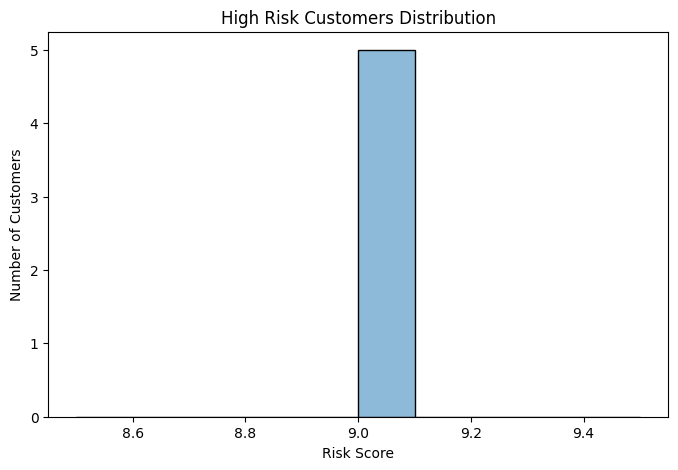

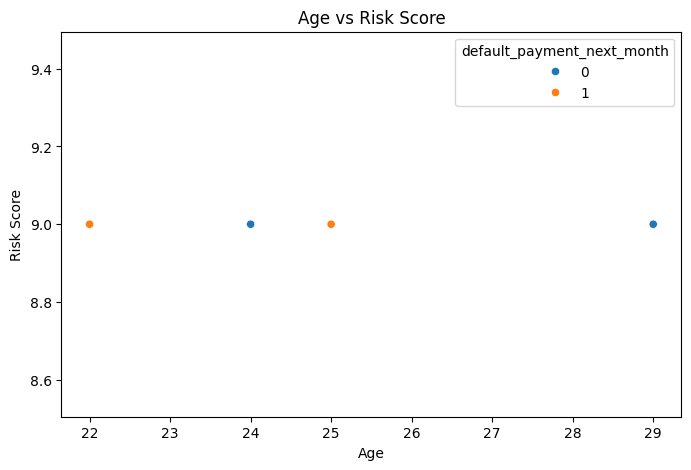

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of risk_score
plt.figure(figsize=(8,5))
sns.histplot(high_risk['risk_score'], bins=10, kde=True)
plt.title("High Risk Customers Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Number of Customers")
plt.show()

# Scatter plot: Age vs Risk Score
plt.figure(figsize=(8,5))
sns.scatterplot(x='AGE', y='risk_score', hue='default_payment_next_month', data=high_risk)
plt.title("Age vs Risk Score")
plt.xlabel("Age")
plt.ylabel("Risk Score")
plt.show()


In [24]:
import pandas as pd

# CSV load
df = pd.read_csv("UCI_Credit_Card.csv")
# Column rename সহজের জন্য
df.rename(columns={'default.payment.next.month':'default_payment_next_month'}, inplace=True)

# Missing values check
print(df.isnull().sum())

# Duplicate rows check
print(df.duplicated().sum())

# First 5 rows
print(df.head())


ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default_payment_next_month    0
dtype: int64
0
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2      

In [25]:
import sqlite3

# Create / Connect SQLite DB
conn = sqlite3.connect("credit_data.db")

# DataFrame -> SQL Table
df.to_sql("credit_card", conn, if_exists="replace", index=False)


30000

In [26]:
# Filter example: AGE>30 এবং default হয়েছে
query_filter = """
SELECT *
FROM credit_card
WHERE AGE > 30 AND default_payment_next_month = 1
LIMIT 5;
"""
filtered = pd.read_sql_query(query_filter, conn)
print(filtered)

# Group by Age & Avg Limit
query_group = """
SELECT AGE, AVG(LIMIT_BAL) as avg_limit, SUM(default_payment_next_month) as defaults
FROM credit_card
GROUP BY AGE
ORDER BY AGE;
"""
age_stats = pd.read_sql_query(query_group, conn)
print(age_stats)


   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0  22   120000.0    2          2         1   39     -1     -1     -1     -1   
1  24   450000.0    2          1         1   40     -2     -2     -2     -2   
2  32    50000.0    1          2         2   33      2      0      0      0   
3  48   150000.0    2          5         2   46      0      0     -1      0   
4  51    70000.0    1          3         2   42      1      2      2      2   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0      632.0      316.0     316.0     316.0       0.0   
1  ...      560.0        0.0        0.0   19428.0    1473.0     560.0   
2  ...    22734.0    23217.0    23680.0    1718.0    1500.0    1000.0   
3  ...     1170.0        0.0        0.0    1013.0    1170.0       0.0   
4  ...    39423.0    38659.0    39362.0       0.0    3100.0    2000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default_payment_next_month  
0     632.0     316.0   

In [32]:
# Add risk_score column
# নতুন column overwrite করে দেওয়া
df['risk_score'] = 0

# Risk rules
df.loc[df['LIMIT_BAL'] < 50000, 'risk_score'] += 2
df.loc[df['AGE'] < 30, 'risk_score'] += 1

# Updated DataFrame আবার SQLite table এ write করা
df.to_sql("credit_card", conn, if_exists="replace", index=False)
conn.execute("UPDATE credit_card SET risk_score = 0;")
conn.execute("UPDATE credit_card SET risk_score = risk_score + 2 WHERE LIMIT_BAL < 50000;")
conn.execute("UPDATE credit_card SET risk_score = risk_score + 1 WHERE AGE < 30;")
conn.commit()


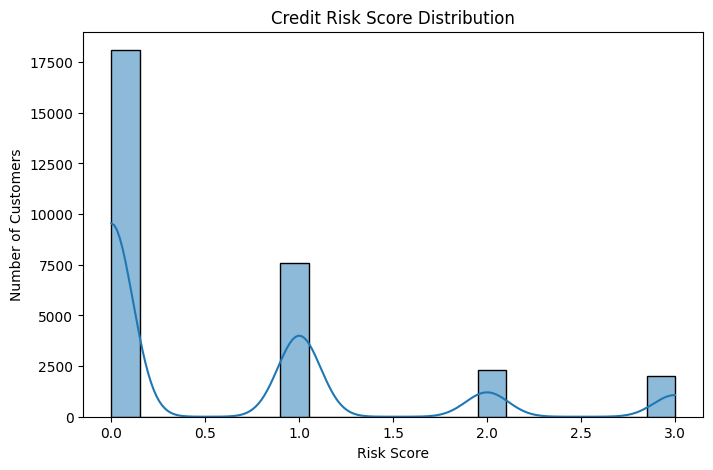

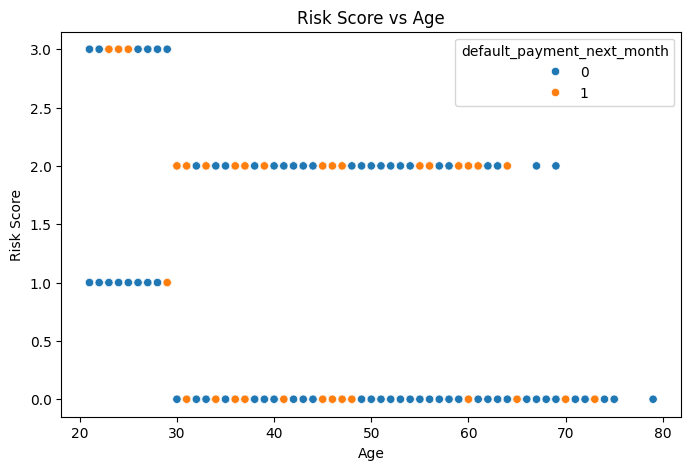

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Risk Score Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['risk_score'], bins=20, kde=True)
plt.title("Credit Risk Score Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Number of Customers")
plt.show()

# Risk Score vs Age
plt.figure(figsize=(8,5))
sns.scatterplot(x='AGE', y='risk_score', hue='default_payment_next_month', data=df)
plt.title("Risk Score vs Age")
plt.xlabel("Age")
plt.ylabel("Risk Score")
plt.show()


In [34]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default_payment_next_month    0
risk_score                    0
dtype: int64

In [35]:
import sqlite3
import pandas as pd

# 1. Open a connection
conn = sqlite3.connect(r"D:\Learning From Zero\python\DATASCIENCE\creditRisk\credit_data.db")

# 2. List table names (optional sanity check)
table_names = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';", conn
)
print("Tables:", table_names['name'].tolist())

# 3. Read a table into DataFrame
df = pd.read_sql_query("SELECT * FROM credit_card;", conn)
print(df.head())

# 4. Close connection
conn.close()


Tables: ['credit_card']
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  \
0  ...        0.0        0.0       0.0     689.0       0.0       0.0   
1  ...     3455.0     3261.0       0.0    1000.0    1000.0    1000.0   
2  ...    14948.0    15549.0    1518.0    1500.0    1000.0    1000.0   
3  ...    28959.0    29547.0    2000.0    2019.0    1200.0    1100.0   
4  ...    19146.0    19131.0    2000.0   36681.0   10000.0    9000.0   

   PAY_AMT5  PAY_AMT6  default_payment_next_month  risk_score  
0   